In [2]:
import os
import shutil
from tqdm import tqdm

import cv2
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("classic")

In [3]:
# import os
# import shutil
# import pandas as pd

# # Define the path to your dataset and metadata
metadata_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
images_dir_part1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/"
images_dir_part2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/"
output_dir = "/kaggle/working/sorted_skin_cancer_images/"

# Define the mapping
mapping = {"akiec": "AKIEC", "bcc": "BCC", "bkl": "BKL", "df": "DF", "mel": "MEL", "nv": "NV", "vasc": "VASC"}

# Load the metadata
df_labels = pd.read_csv(metadata_path)

# Create directories for each class if they don't already exist
for label in mapping.values():
    class_dir = os.path.join(output_dir, label)
    os.makedirs(class_dir, exist_ok=True)

# Copy images to their respective class directories
for _, row in df_labels.iterrows():
    image_id = row['image_id']
    label = row['dx']
    image_filename = f"{image_id}.jpg"
    
    # Determine which part the image is in and set the full path
    if os.path.exists(os.path.join(images_dir_part1, image_filename)):
        src_path = os.path.join(images_dir_part1, image_filename)
    else:
        src_path = os.path.join(images_dir_part2, image_filename)
    
    dest_path = os.path.join(output_dir, mapping[label], image_filename)
    
    # Copy the image to the appropriate directory
    shutil.copy(src_path, dest_path)

print("Dataset structured successfully.")

Dataset structured successfully.


In [4]:
# Define the path to your sorted dataset
output_dir = "/kaggle/working/sorted_skin_cancer_images/"

# Get the number of files in each class directory
class_counts = {}
for class_name in os.listdir(output_dir):
    class_dir = os.path.join(output_dir, class_name)
    if os.path.isdir(class_dir):
        num_files = len(os.listdir(class_dir))
        class_counts[class_name] = num_files

# Print the number of files in each directory
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

NV: 6705 images
DF: 115 images
AKIEC: 327 images
BKL: 1099 images
BCC: 514 images
VASC: 142 images
MEL: 1113 images


In [5]:
from sklearn.utils import class_weight

# Map the labels in the dataframe to the new labels
df_labels['label_mapped'] = df_labels['dx'].map(mapping)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(df_labels["label_mapped"]),
                                                  y=df_labels["label_mapped"])

# Convert class weights to a dictionary
class_wt_dict = dict(zip(np.unique(df_labels["label_mapped"]), class_weights))

class_wt_dict

{'AKIEC': 4.375273044997815,
 'BCC': 2.78349082823791,
 'BKL': 1.301832835044846,
 'DF': 12.440993788819876,
 'MEL': 1.2854575792581184,
 'NV': 0.21338020666879728,
 'VASC': 10.075452716297788}

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input as base_preprocess


image_gen = ImageDataGenerator(
                               preprocessing_function=base_preprocess,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               # rescale=1/255,
                               validation_split=0.15)

In [7]:
data_dir = output_dir
batch_size = 64
target_size = (224,224)
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


<Axes: ylabel='count'>

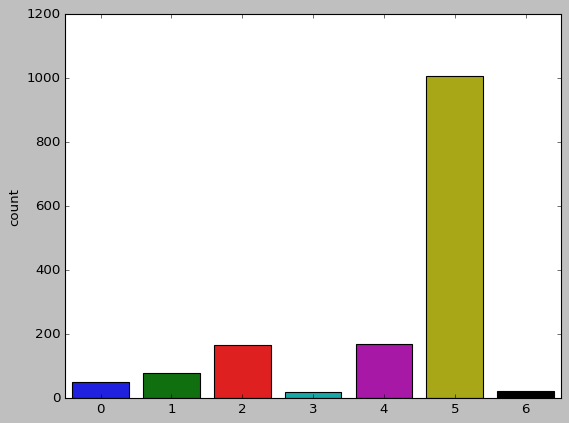

In [8]:
sns.countplot(x=test_image_gen.classes)

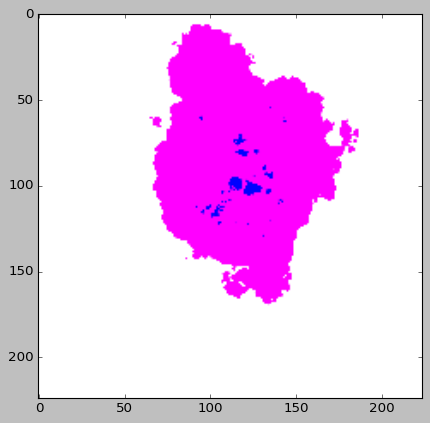

In [9]:
plt.imshow(train_image_gen[0][0][0])

In [10]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)


tl_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 24,060,935 (91.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('model_resnet.keras',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [14]:
history = tl_model.fit(train_image_gen,
                    epochs=15, 
                    validation_data = test_image_gen,
                    class_weight=class_wt_dict,
                    callbacks=callback_list)

Epoch 1/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - accuracy: 0.8755 - loss: 2.6009
Epoch 1: val_accuracy improved from 0.83522 to 0.83789, saving model to model_resnet.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.8755 - loss: 2.6000 - val_accuracy: 0.8379 - val_loss: 2.3722 - learning_rate: 1.0000e-04
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.8971 - loss: 2.0668
Epoch 2: val_accuracy did not improve from 0.83789
134/134 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.8971 - loss: 2.0662 - val_accuracy: 0.8306 - val_loss: 2.1347 - learning_rate: 1.0000e-04
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.9055 - loss: 1.6878
Epoch 3: val_accuracy improved from 0.83789 to 0.84990, saving model to model_resnet.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9055 - loss: 1.6873 - val_accuracy: 0.8499 - val_loss: 1.6565 - learning_rate: 1.0000e-04
Epoch 4/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy:

In [15]:
df=pd.DataFrame(tl_model.history.history)
df.to_csv('hist.csv')


<Axes: >

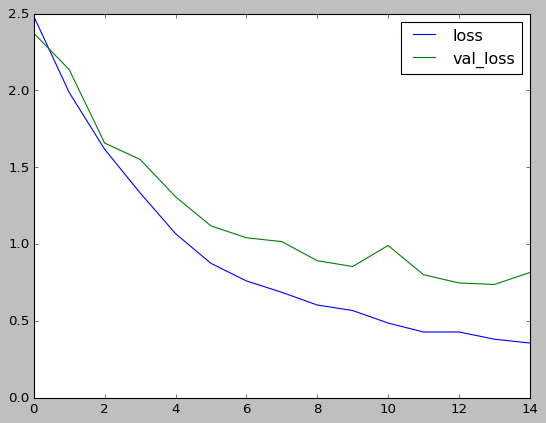

In [16]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

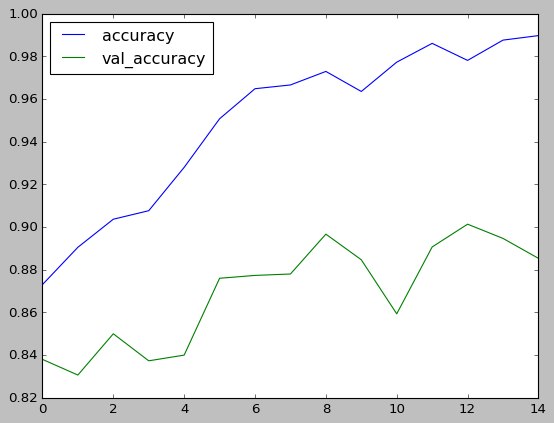

In [17]:
metrics[["accuracy","val_accuracy"]].plot()

In [18]:
tl_model.evaluate(test_image_gen)

24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 982ms/step - accuracy: 0.8244 - loss: 1.1005


[0.7981032133102417, 0.89192795753479]

In [19]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = test_image_gen.classes

24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step 


In [20]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)

Normalized confusion matrix


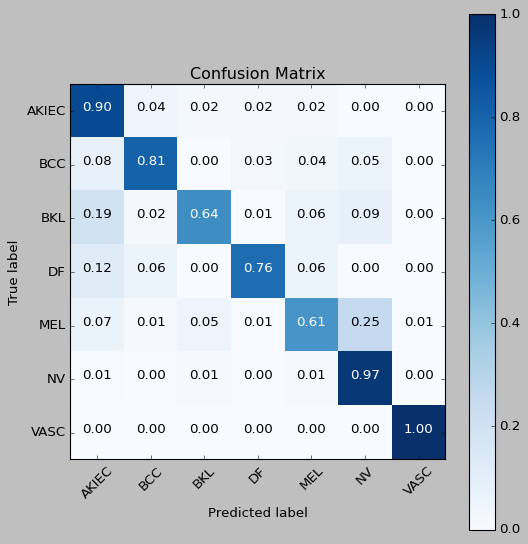

In [21]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = list(test_image_gen.class_indices.keys())
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)


In [22]:
print(classification_report(test_image_gen.classes, predictions, zero_division=0))
       

              precision    recall  f1-score   support

           0       0.44      0.90      0.59        49
           1       0.87      0.81      0.84        77
           2       0.86      0.64      0.73       164
           3       0.68      0.76      0.72        17
           4       0.78      0.61      0.68       166
           5       0.94      0.97      0.96      1005
           6       0.95      1.00      0.98        21

    accuracy                           0.88      1499
   macro avg       0.79      0.81      0.79      1499
weighted avg       0.89      0.88      0.88      1499

